# **Cross-Validation Analysis:**


In [3]:
#Añadiendo los paquetes necesarios
using Pkg
Pkg.add("GLM")
Pkg.add("DataFrames")
Pkg.add("DelimitedFiles")
Pkg.add("RData")
Pkg.add("Random")
Pkg.add("Lasso")
Pkg.add("DataStructures")
Pkg.add("NamedArrays")
Pkg.add("PrettyTables")
Pkg.add("Plots")


   Resolving package versions...
  No Changes to `C:\Users\Alvaro\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\Alvaro\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Alvaro\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\Alvaro\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Alvaro\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\Alvaro\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Alvaro\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\Alvaro\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Alvaro\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\Alvaro\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Alvaro\.julia\environments\v1.11\Project.

In [4]:
using GLM, DataFrames, Random, RData, Lasso, LinearAlgebra, Statistics, DataStructures, NamedArrays, PrettyTables, Plots

In [5]:
#Carpeta Inicio
pwd()

"C:\\Users\\Alvaro\\Documents\\GitHub\\CausalAI-Course\\labs\\replication_1"

In [8]:
#1. Reading the Data
Data = load("wage2015_subsample_inference.Rdata")
Data = Data["data"]
Data[1:5,:]

Row,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Cat…,Cat…,Cat…,Cat…
1,9.61538,2.26336,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7.0,0.49,0.343,0.2401,3600,11,8370,18
2,48.0769,3.8728,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,31.0,9.61,29.791,92.3521,3050,10,5070,9
3,11.0577,2.40313,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18.0,3.24,5.832,10.4976,6260,19,770,4
4,13.9423,2.63493,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,25.0,6.25,15.625,39.0625,420,1,6990,12
5,28.8462,3.36198,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,22.0,4.84,10.648,23.4256,2015,6,9470,22


In [9]:
#2. Setting the Alpha Vector
Alpha_Vector = [0.1, 0.2,0.3,0.4,0.5]



5-element Vector{Float64}:
 0.1
 0.2
 0.3
 0.4
 0.5

In [12]:
#3. Shuffle and Folds Generation
Random.seed!(123)  # Set a random seed for reproducibility
Data_Shuffled = shuffle!(Data)
k_folds = 10
Fold_Size = Int.(size(Data)[1] / k_folds)
Fold_List = []

for number in 1:k_folds
    Fold_Generation = (Data_Shuffled[1+Fold_Size*(number-1):Fold_Size*(number),:])
    push!(Fold_List, Fold_Generation)
end

Validation_fold = Fold_List[10]
Training_Folds = Fold_List[1:9,:]
Training_Folds[1:1,:]

1×1 Matrix{Any}:
 515×20 DataFrame
 Row │ wage      lwage    sex      shs      hsg      scl      clg      ad      ⋯
     │ Float64   Float64  Float64  Float64  Float64  Float64  Float64  Float64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 27.7778   3.32424      0.0      0.0      0.0      1.0      0.0      0.0 ⋯
   2 │ 12.6374   2.53666      1.0      0.0      1.0      0.0      0.0      0.0
   3 │ 35.7143   3.57555      0.0      0.0      0.0      0.0      1.0      0.0
   4 │ 19.2308   2.95651      1.0      0.0      0.0      0.0      1.0      0.0
   5 │ 61.0577   4.11182      0.0      0.0      0.0      1.0      0.0      0.0 ⋯
   6 │ 19.2308   2.95651      0.0      0.0      1.0      0.0      0.0      0.0
   7 │ 13.7363   2.62004      0.0      0.0      0.0      1.0      0.0      0.0
   8 │ 28.8462   3.36198      0.0      0.0      0.0      1.0      0.0      0.0
   9 │ 21.6346   3.07429      0.0      0.0      0.0      1.0      0.0      0.0 ⋯
  10 

In [ ]:
Validation_fold

In [13]:
#4. Lasso Function

function lasso_implementation(dataframe, tested, alpha_value)
    Y = dataframe[!,"wage"]
    Y = DataFrame([Y],[:Y])
    D = dataframe[!,"sex"]
    D = DataFrame([D],[:D])
    W = select(dataframe, Not(["lwage","wage", "sex","occ","occ2","ind","ind2"]))
    data = [Y D W]
    lasso_model = fit(LassoModel, term(:Y) ~  sum(term.(names(data[!, Not(["Y", "D"])]))), data; α = alpha_value)
    Y = tested[!,"wage"]
    Y = DataFrame([Y],[:Y])
    D = tested[!,"sex"]
    D = DataFrame([D],[:D])
    W = select(tested, Not(["lwage","wage", "sex","occ","occ2","ind","ind2"]))
    data_tested = [D W]
    Y_predict = predict(lasso_model, data_tested)
    Y = tested[!,"wage"]
    MSE = mean((Y_predict .- Y).^2)
    return MSE, lasso_model
end





lasso_implementation (generic function with 1 method)

In [14]:
#5. Cross Validation
MSE_Averages = []
for alpha in Alpha_Vector
    MSE_List = []
    for i in 1:k_folds-1
        tested_fold = Training_Folds[i,:][1]
        Current_Folds = [Training_Folds[z] for z in 1:length(Training_Folds) if !(z == i)]
        Combined_dataframe = vcat(Current_Folds...)
        MSE_current = lasso_implementation(Combined_dataframe,tested_fold,alpha)
        push!(MSE_List, MSE_current[1])
    end
    MSE_Mean = mean(MSE_List)
    println("MSE for this alpha ",alpha,": ",MSE_Mean)
    Alpha_MSE = [MSE_Mean, alpha]
    push!(MSE_Averages, Alpha_MSE)
end



MSE for this alpha 0.1: 377.5886839530642
MSE for this alpha 0.2: 377.5674699318595
MSE for this alpha 0.3: 377.58808206700076
MSE for this alpha 0.4: 377.5686274653626
MSE for this alpha 0.5: 377.55952858260093


In [15]:
#6. Selecting Optimal Alpha

MSE_Averages_Final = []
for i in MSE_Averages
    push!(MSE_Averages_Final, i[1])
end
min_value = minimum(MSE_Averages_Final)
index = findfirst(x -> x == min_value, MSE_Averages_Final)

Optimal_Alpha = MSE_Averages[index][2]
println("Optimal Alpha: ",Optimal_Alpha)
println("Optimal MSE: ",MSE_Averages[index][1])

Optimal Alpha: 0.5
Optimal MSE: 377.55952858260093


In [16]:
#7. Final Training Set
Combined_dataframe = vcat(Training_Folds...)
Last_Alpha = lasso_implementation(Combined_dataframe, Validation_fold, Optimal_Alpha)
MSE = Last_Alpha[1]
println("Final MSE: ", MSE)

#Due to the lower MSE we can say that this model can be generalized and be more useful for prediction than otherwise

Final MSE: 678.789840018009


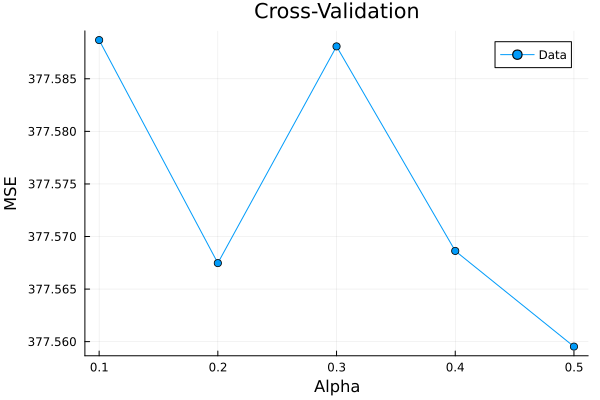

In [17]:
#8. Plotting
plot(Alpha_Vector, MSE_Averages_Final, xlabel="Alpha", ylabel="MSE", title="Cross-Validation", label="Data", marker=:circle)


